# Detrending Periodic Motions in Video

The goal of this notebook is to demonstrate a proof of concept for cleaning up periodic motions in videos.  If the input is a periodically oscillating blob with an additive random walk, the network will try to remove the random walk and only be left with the periodic motion

In [1]:
%load_ext autoreload
%autoreload 2

from topologylayer.nn import AlphaLayer, BarcodePolyFeature, PartialSumBarcodeLengths
from gtda.plotting import plot_point_cloud
from persim import plot_diagrams
from takenslayers import *
from videoutils import *
import matplotlib.pyplot as plt
import topologylayer

import math

import numpy as np
from scipy.signal import convolve

import torch
from torch.autograd import Variable
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision.transforms as T

torch.manual_seed(2)

In [2]:
M = 64
N = 64
L = 8
n_frames = 300
amp = 20
n_periods = 10
win = int(n_frames/n_periods)
noise_amp = 8
gauss = True
np.random.seed(0)
frames, X = simulate_moving_blob(M, N, L, n_frames, amp, n_periods, noise_amp, gauss)
frames_orig = frames.copy()

In [3]:
save_video("blob.avi", frames, 30)

Text(0.5, 1.0, 'Y Coordinate')

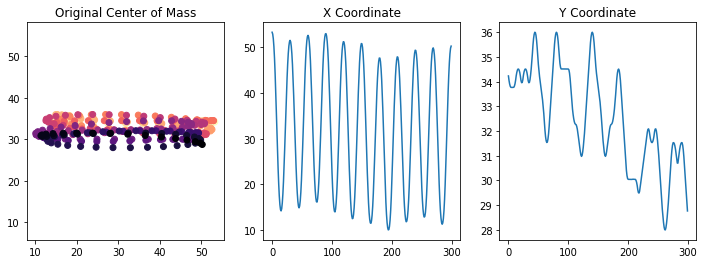

In [4]:
frames = np.array(frames, dtype=float)/255
X = get_blob_cm(frames)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=np.arange(n_frames), cmap='magma_r')
plt.title("Original Center of Mass")
plt.axis("equal")
plt.subplot(132)
plt.plot(X[:, 0])
plt.title("X Coordinate")
plt.subplot(133)
plt.plot(X[:, 1])
plt.title("Y Coordinate")

(300, 1, 64, 64)
0.996078431372549


Text(0.5, 1.0, 'Original Persistence Diagram')

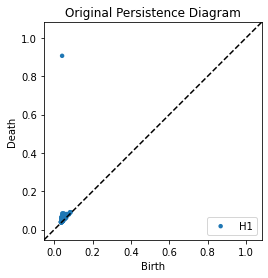

In [5]:
X = frames[:, :, 0, :]
X = np.moveaxis(X, [0, 1, 2], [1, 2, 0])
X = X[:, None, :, :]
print(X.shape)
print(np.max(X))

data = torch.from_numpy(X).float()

vid_dist = SlidingVideoDistanceMatrix(win, 'cpu')
rips = RipsPersistenceDistance([1])
dgm = rips(vid_dist(data))[0]
plot_diagrams(dgm.detach().numpy(), labels=["H1"])
plt.title("Original Persistence Diagram")

win =  30
cpu


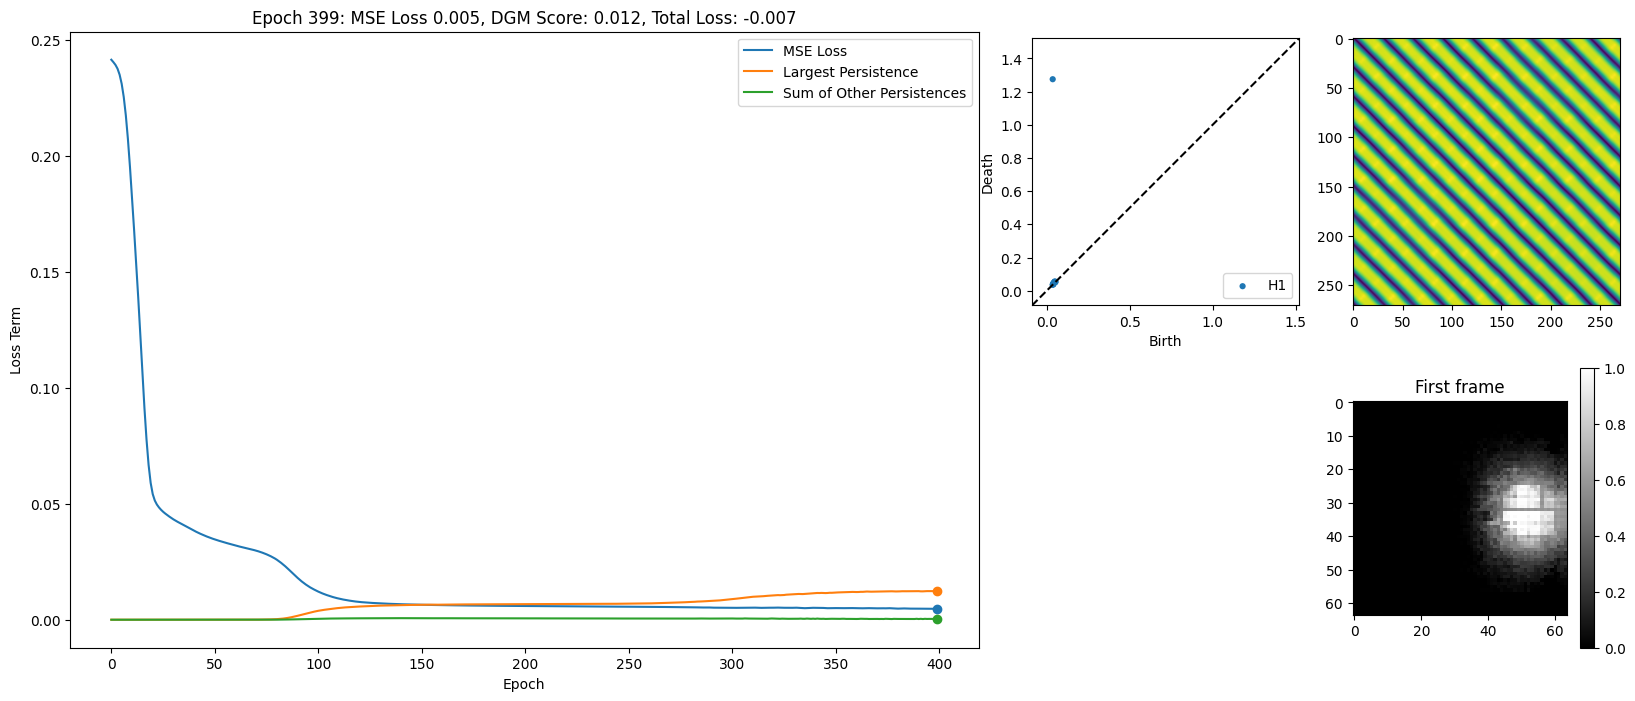

In [6]:
class AutoencoderCNN(nn.Module):
    def __init__(self, device, x, depth, dim, win, lam=1, lr=1e-2):
        """
        Parameters
        ----------
        x: tensor(n_frames, 1, imgres, imgres)
            Original video
        depth: int
            Depth of the CNN
        dim: int
            Dimension of the latent space
        win: int
            Window length of sliding window
        lam: float
            Weight of topological regularization
        lr: float
            Learning rate
        """
        super(AutoencoderCNN, self).__init__()
        self.device = device
        self.x = x
        imgres = x.shape[-1]
        self.depth = depth
        self.dim = dim
        self.win = win
        self.dim = dim
        self.lam = lam
        
        ## Step 1: Create Convolutional Down Network
        self.convdown = nn.ModuleList()
        lastchannels = 1
        channels = 16
        for i in range(depth):
            self.convdown.append(nn.Conv2d(lastchannels, channels, 3, stride=2, padding=1))
            self.convdown.append(nn.ReLU())
            lastchannels = channels
            if i < depth-1:
                channels *= 2
        if dim > 0:
            flatten = nn.Flatten()
            res_down = int(imgres/(2**depth))
            flatten_dim = channels*res_down**2
            latentdown = nn.Linear(flatten_dim, dim)
            latentdown_relu = nn.ReLU()
            self.convdown += [flatten, latentdown, latentdown_relu]
        
        ## Step 2: Create Convolutional up layer
        self.convup = nn.ModuleList()
        if dim > 0:
            latentup = nn.Linear(dim, flatten_dim)
            latentup_relu = nn.ReLU()
            reshape = nn.Unflatten(1, (channels, res_down, res_down))
            self.convup += [latentup, latentup_relu, reshape]
        for i in range(depth):
            nextchannels = channels//2
            if i == depth-1:
                nextchannels = 1
            self.convup.append(nn.ConvTranspose2d(channels, nextchannels, 3, stride=2, padding=1, output_padding=1))
            channels = channels//2
            if i < depth-1:
                self.convup.append(nn.ReLU())
            else:
                self.convup.append(nn.Sigmoid())
        
        ## Step 3: Create layers for sliding window
        self.vid_dist = SlidingVideoDistanceMatrix(win, device)
        self.rips = RipsPersistenceDistance([1])
        
        # Optimizer / Loss functions
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.mse_loss = nn.MSELoss()
        # NOTE: These are actually H1, I just don't compute H0
        self.sum_h1_loss = PartialSumBarcodeLengths(dim=0, skip=0) 
        self.skip1_sum_h1_loss = PartialSumBarcodeLengths(dim=0, skip=1)
        self.losses = []
    
    def forward(self):
        y = self.x
        for layer in self.convdown:
            y = layer(y)
        for layer in self.convup:
            y = layer(y)
        D = self.vid_dist(y)
        dgms = self.rips(D.cpu())
        return y, D, dgms
    
    def train_step(self):
        self.optimizer.zero_grad()
        self.train()
        y, D, dgms = self.forward()
        mse_loss = self.mse_loss(self.x, y)
        sum_h1_loss = self.sum_h1_loss((dgms, True))
        skip1_sum_h1_loss = self.skip1_sum_h1_loss((dgms, True))
        largest_pers = sum_h1_loss-skip1_sum_h1_loss
        dgm_score = largest_pers-skip1_sum_h1_loss
        loss = mse_loss - self.lam*dgm_score
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())
        return y, D, dgms, mse_loss.item(), self.lam*largest_pers.item(), self.lam*skip1_sum_h1_loss.item()

    def train_epochs(self, num_epochs):
        self.losses = []
        plot_idx = 0
        res = 4
        plt.figure(figsize=(res*5, res*2))
        y = None
        mse_losses = []
        largest_perses = []
        sum_other_persistences = []
        for epoch in range(num_epochs):
            y, D, dgms, mse_loss, largest_pers, sum_other_persistence = self.train_step()
            
            ## Everything below this point is just for plotting
            mse_losses.append(mse_loss)
            largest_perses.append(largest_pers)
            sum_other_persistences.append(sum_other_persistence)
            dgm_score = largest_pers-sum_other_persistence
            
            if plot_idx%40 == 0 or plot_idx == num_epochs-1:
                plt.clf()
                plt.subplot2grid((2, 5), (0, 0), colspan=3, rowspan=2)
                plt.title("Epoch {}: MSE Loss {:.3f}, DGM Score: {:.3f}, Total Loss: {:.3f}".format(epoch, mse_loss, dgm_score, self.losses[-1]))
                plt.plot(mse_losses)
                plt.plot(largest_perses)
                plt.plot(sum_other_persistences)
                plt.legend(["MSE Loss", "Largest Persistence", "Sum of Other Persistences"])
                plt.scatter([epoch], [mse_loss], c='C0')
                plt.scatter([epoch], [largest_pers], c='C1')
                plt.scatter([epoch], [sum_other_persistence], c='C2')
                #plt.ylim([0, np.quantile(np.concatenate((mse_losses, dgm_losses, birth_losses)), 0.99)])
                plt.xlabel("Epoch")
                plt.ylabel("Loss Term")


                plt.subplot2grid((2, 5), (0, 3))
                dgms = dgms[0].detach().numpy()
                if dgms.size > 0:
                    plot_diagrams(dgms, labels=["H1"])

                plt.subplot2grid((2, 5), (0, 4))
                plt.imshow(D.cpu().detach().numpy())

                plt.subplot2grid((2, 5), (1, 4))
                I = y.cpu().detach().numpy()[0, 0, :, :]
                plt.imshow(I, cmap='gray', vmin=0, vmax=1)
                plt.colorbar()
                plt.title("First frame")


                plt.savefig("Iter{}.png".format(plot_idx), facecolor='white')
            plot_idx += 1
        return y



def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return 'cpu'#device

print("win = ", win)
device = get_device()
print(device)
data = data.to(device)
autoencoder = AutoencoderCNN(device, data, depth=2, dim=50, win=win, lam=0.01, lr=0.001)
autoencoder = autoencoder.to(device)

y = autoencoder.train_epochs(400)


(64, 64, 3, 300)


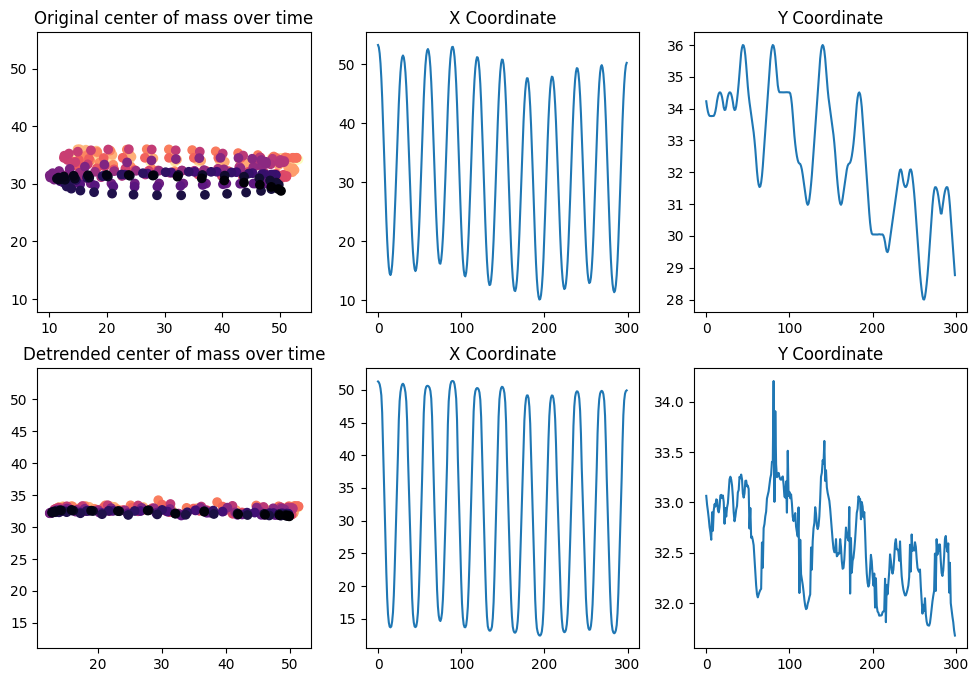

In [7]:
res = y.cpu().detach().numpy()
frames_res = np.moveaxis(res, (2, 3, 0, 1), (0, 1, 3, 2))

X = get_blob_cm(frames_res)
X_orig = get_blob_cm(frames_orig)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.scatter(X_orig[:, 0], X_orig[:, 1], c=np.arange(n_frames), cmap='magma_r')
plt.title("Original center of mass over time")
plt.axis("equal")
plt.subplot(232)
plt.plot(X_orig[:, 0])
plt.title("X Coordinate")
plt.subplot(233)
plt.plot(X_orig[:, 1])
plt.title("Y Coordinate")
plt.subplot(234)
plt.scatter(X[:, 0], X[:, 1], c=np.arange(n_frames), cmap='magma_r')
plt.title("Detrended center of mass over time")
plt.axis("equal")
plt.subplot(235)
plt.plot(X[:, 0])
plt.title("X Coordinate")
plt.subplot(236)
plt.plot(X[:, 1])
plt.title("Y Coordinate")

frames_res = np.array(frames_res*255, dtype=np.uint8)
save_video("res.avi", frames_res, 30)

composite = np.concatenate((frames_res, frames_res, frames_orig[:, :, 0:1, :]), axis=2)
save_video("res_composite.avi", composite, 30)